In [2]:
from sklearn import tree
from nltk.corpus import stopwords
import spacy
import pandas as pd
import numpy as np
import graphviz 
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
from nltk.corpus import wordnet as wn

load data

In [3]:
hs = pd.read_csv("./TempData/model_data.csv")
mlma = pd.read_csv("./TempData/mlma_dataset.csv")
df = pd.concat([hs,mlma], axis=0, ignore_index=True)
df.head()

,Unnamed: 0,text,label
0,0,These girls are the equivalent of the irritati...,racism
1,1,Who is writing the bimbolines? #mkr,sexism
2,2,"Colin will save them. They're pretty blondes, ...",sexism
3,3,Which will end first: #mkr or Tony Abbott as PM?,none
4,4,RT @TheAngelaOfOz: That's bullshit Colin and y...,none


load models and stopwords

In [4]:
nlp = spacy.load("en_core_web_sm")
vectorizer = CountVectorizer(token_pattern = r"\b\w+\b")
words_for_exclusion = ['rt','amp','kat','-PRON-']
stop_words = set(stopwords.words('english') + words_for_exclusion) 

Corpus lemmatization

In [15]:
corpus = []
Y = np.zeros((len(df['text'])))
for idx, row in df.iterrows():
    doc = nlp(row['text']) # spacy sintactic parsing
    filtered_sentence = []
    filtered_sentence = [t.lemma_ for t in doc if  not t.lemma_ in stop_words and t.pos_ not in ["PUNCT",'PROPN'] and wn.synsets(t.lemma_)] 
    corpus.append(" ".join(filtered_sentence))
    if row['label'] not in ['none','normal']:
        Y[idx] = 1
    
print(corpus[:10])

['girl equivalent irritate asian girl couple year ago well 7', 'write', 'save pretty blonde keep tell', 'end first pm', 'bullshit know', 'cook half bird idiot', 'cook half bird idiot', 'cook half bird idiot', 'cook half bird idiot', 'stop say dumb blonde pretty face need pretty face pull']


transform corpus to word vector ()

In [16]:
X = vectorizer.fit_transform(corpus)
print(X.data)

[2 1 1 ... 1 1 1]


Create and fit tree

In [17]:
clf = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10)
clf = clf.fit(X, Y)

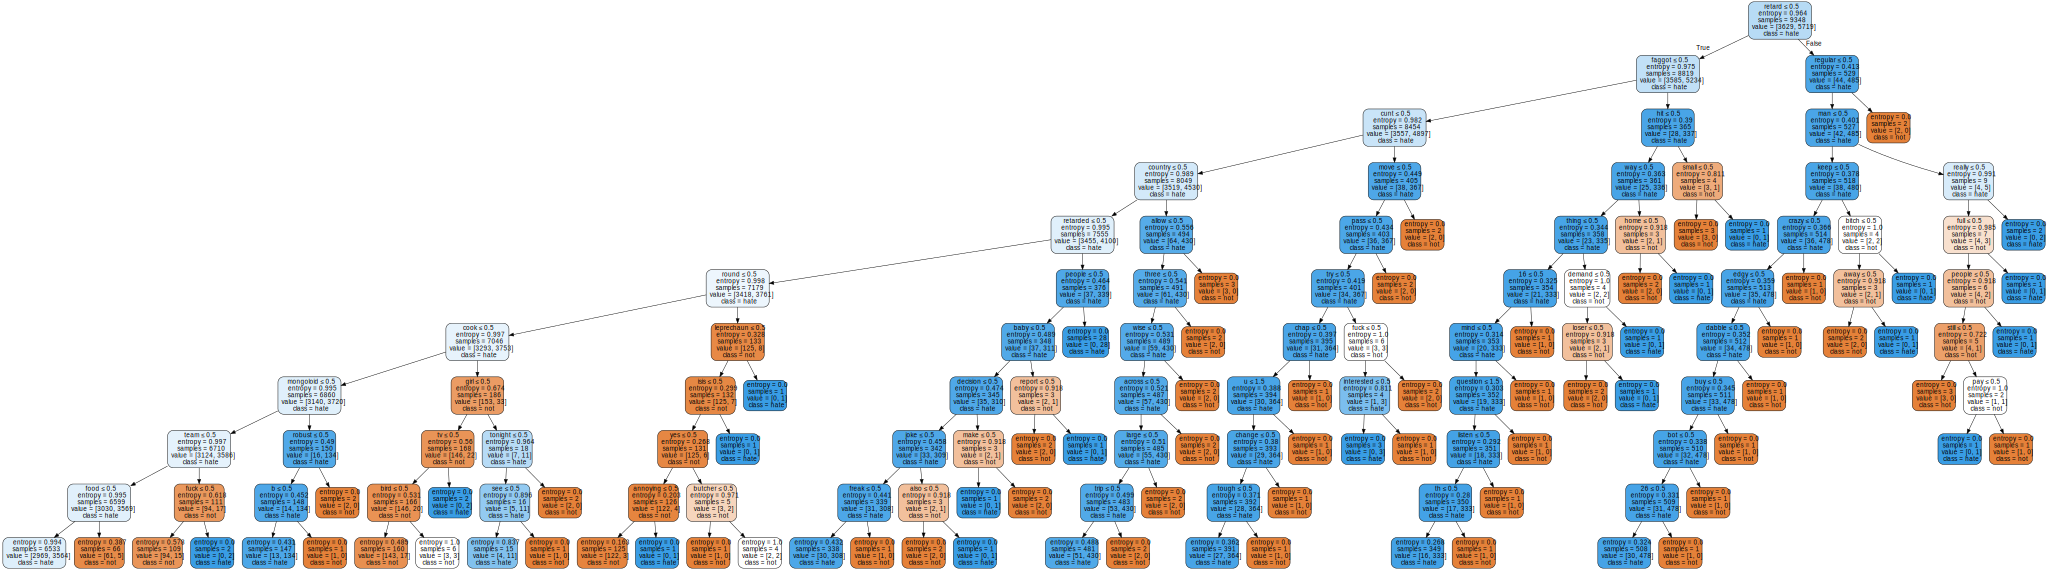

In [18]:
dot_data = tree.export_graphviz(clf, out_file=None,
    class_names=['not','hate'],
    feature_names=vectorizer.get_feature_names(),
    filled=True, rounded=True,  special_characters=True) 

graph = graphviz.Source(dot_data) 
graph.render("./twitter_data/tree") 

display(graphviz.Source(dot_data))

In [66]:
a = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

In [67]:
a.head()

,0,1,10,100,1000,105,10th,11,110,11th,...,zero,zimbabwe,zing,zionist,zip,zombie,zombies,zone,zoo,zucchini
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
a.to_csv("./twitter_data/word_vector.csv")

# Interative plot

In [69]:
labels = vectorizer.get_feature_names()
def plot_tree(crit, split, depth, min_split, min_leaf=0.2):
    estimator = tree.DecisionTreeClassifier(random_state = 0 
      , criterion = crit
      , splitter = split
      , max_depth = depth
      , min_samples_split=min_split
      , min_samples_leaf=min_leaf)
    estimator.fit(X, Y)
    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['not','hate']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

In [71]:
inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , split = ["best", "random"]
   , depth=[20,30,40,50,60,70,80,100]
   , min_split=(0.1,1)
   , min_leaf=(0.1,0.5))

display(inter)

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…